<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/5_1_KMeans_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

K-means clustering partitions $ N $ data points into $ K $ clusters such that any point is assigned to the cluster with the closest center, or centroid.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

# Distance Functions in Clustering

Clustering algorithms rely on distance functions to measure the similarity or dissimilarity between data points. The choice of distance function significantly impacts the structure of the resulting clusters. Below are the distance functions referenced in the provided sources.

## Euclidean Distance

Euclidean distance is the most commonly used metric in clustering, measuring the straight-line distance between two points in a multi-dimensional space:

$$
d(x_i, x_j) = \sqrt{\sum_{n=1}^{D} (x_{i,n} - x_{j,n})^2}
$$

where:
- $ x_i $ and $ x_j $ are two points in a $ D $-dimensional space.
- The function computes the sum of squared differences between corresponding coordinates.

In [67]:

def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

x = np.array([1, 2, 3])
y = np.array([4, 5, 6])

print("Euclidean Distance:", euclidean_distance(x, y))


Euclidean Distance: 5.196152422706632


## Cosine Similarity

Cosine similarity measures the cosine of the angle between two vectors. It evaluates their directional similarity rather than their magnitude:

$$
\text{sim}(x_i, x_j) = \frac{\sum_{n=1}^{D} x_{i,n} x_{j,n}}{\sqrt{\sum_{n=1}^{D} x_{i,n}^2} \cdot \sqrt{\sum_{n=1}^{D} x_{j,n}^2}}
$$

This measure is widely used in text mining and document clustering, where vector magnitudes may not be as significant as their orientation.

To convert cosine similarity into a distance metric:

$$
d(x_i, x_j) = 1 - \text{sim}(x_i, x_j)
$$

This transformation ensures a higher distance corresponds to greater dissimilarity.

In [68]:
def cosine_similarity(x, y):
    dot_product = np.dot(x, y)
    magnitude_x = np.sqrt(np.sum(x ** 2))
    magnitude_y = np.sqrt(np.sum(y ** 2))
    return dot_product / (magnitude_x * magnitude_y)


print("Cosine Similarity:", cosine_similarity(x, y))

Cosine Similarity: 0.9746318461970762


## Manhattan Distance

Manhattan distance, also known as the taxicab or city-block distance, measures the sum of absolute differences between corresponding coordinates:

$$
d(x_i, x_j) = \sum_{n=1}^{D} |x_{i,n} - x_{j,n}|
$$

This metric is particularly useful in grid-based data structures where movement is restricted to horizontal and vertical paths.

In [69]:
def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))


print("Manhattan Distance:", manhattan_distance(x, y))

Manhattan Distance: 9


## Jaccard Similarity

Jaccard similarity is used to compare the similarity of two sets and is defined as:

$$
\text{sim}(x_i, x_j) = \frac{|x_i \cap x_j|}{|x_i \cup x_j|}
$$

This metric is useful when working with categorical or binary data, such as document similarity tasks.

In [70]:
def jaccard_similarity(x, y):
    intersection = np.sum(np.minimum(x, y))
    union = np.sum(np.maximum(x, y))
    return intersection / union if union != 0 else 0

print("Jaccard Similarity:", jaccard_similarity(x, y))

Jaccard Similarity: 0.4


## Minkowski Distance

Minkowski distance generalizes both Euclidean and Manhattan distances. It is defined as:

$$
d(x_i, x_j) = \left( \sum_{n=1}^{D} |x_{i,n} - x_{j,n}|^p \right)^{\frac{1}{p}}
$$

where:
- $ p = 1 $ results in Manhattan distance,
- $ p = 2 $ results in Euclidean distance.

By adjusting $ p $, one can control the sensitivity of the distance measurement.

In [71]:
def minkowski_distance(x, y, p):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

print("Minkowski Distance (p=3):", minkowski_distance(x, y, 3))

Minkowski Distance (p=3): 4.3267487109222245


## Mahalanobis Distance

Mahalanobis distance accounts for correlations between features and scales the distances accordingly:

$$
d(x_i, x_j) = \sqrt{(x_i - x_j)^T S^{-1} (x_i - x_j)}
$$

where:
- $ S $ is the covariance matrix of the dataset.
- Unlike Euclidean distance, it accounts for the shape of the data distribution.

In [72]:
def minkowski_distance(x, y, p):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

print("Minkowski Distance (p=3):", minkowski_distance(x, y, 3))

Minkowski Distance (p=3): 4.3267487109222245


## Hamming Distance

Hamming distance measures the number of positions at which two binary vectors differ:

$$
d(x_i, x_j) = \sum_{n=1}^{D} \mathbf{1}(x_{i,n} \neq x_{j,n})
$$

where $ \mathbf{1}(\cdot) $ is an indicator function that returns 1 if the condition inside is true, otherwise 0.

Hamming distance is primarily used in text processing, error detection, and binary feature comparisons.


In [73]:
def hamming_distance(x, y):
    return np.sum(x != y)

print("Hamming Distance:", hamming_distance(x, y))

Hamming Distance: 3


# Algorithm

## Calculating Centroids

K-Means clustering is an iterative algorithm that partitions a dataset into $ K $ clusters by minimizing the sum of squared distances between points and their assigned cluster centers. The algorithm follows an expectation-maximization framework, where the centroid update step plays a crucial role in refining the cluster assignments.


Initially, the algorithm assigns each data point to the cluster whose centroid is closest based on a chosen distance metric, commonly the Euclidean distance

After all points have been assigned to clusters, the centroids are updated by computing the mean of all points within each cluster:

$$
\mu_k = \frac{\sum_{n=1}^{N} r_{nk} x_n}{\sum_{n=1}^{N} r_{nk}}
$$

where $ r_{nk} $ is an indicator variable that equals 1 if $ x_n $ belongs to cluster $ k $  and 0 otherwise. This formula ensures that the new centroid is the arithmetic mean of all points assigned to the cluster.


The assignment and update steps are repeated iteratively until the centroids stabilize, meaning their positions no longer change significantly. Convergence can be determined using various stopping criteria, such as:

- No significant change in centroids between iterations.
- A predefined maximum number of iterations is reached.
- The reduction in clustering error is below a given threshold.



In [74]:
def calculate_centroids(data, labels, k):
    centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        cluster_points = data[labels == i]
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)
    return centroids

data = np.array([
    [1, 2], [1, 3], [2, 2], [8, 7], [8, 8], [7, 7]
])
labels = np.array([0, 0, 0, 1, 1, 1])
k = 2
centroids = calculate_centroids(data, labels, k)
print("Calculated Centroids:\n", centroids)


Calculated Centroids:
 [[1.33333333 2.33333333]
 [7.66666667 7.33333333]]


In [75]:
def assign_clusters(data, centroids, distance_function=euclidean_distance):
    labels = np.zeros(data.shape[0], dtype=int)
    for i, point in enumerate(data):
        distances = np.array([distance_function(point, centroid) for centroid in centroids])
        labels[i] = np.argmin(distances)
    return labels

print("Assigned Clusters:", assign_clusters(data, centroids))

Assigned Clusters: [0 0 0 1 1 1]


## Distortion Function

K-Means clustering aims to minimize the total sum of squared Euclidean distances between data points and their assigned centroids. This is represented by the **distortion function**, also known as the **within-cluster sum of squares (WCSS)** or **inertia**.

$$
J = \sum_{n=1}^{N} \sum_{k=1}^{K} r_{nk} \| x_n - \mu_k \|^2
$$

where:
- $J$ is the objective function, representing the clustering error.
- $N$ is the total number of data points.
- $K$ is the number of clusters.
- $x_n$ is the $n$-th data point.
- $\mu_k$ is the centroid of cluster $k$.
- $r_{nk}$ is a binary indicator that equals $1$ if $x_n$ belongs to cluster $k$, otherwise $0$.



In [76]:
def distortion_function(data, centroids, labels, distance_function=euclidean_distance):
    cost = 0
    for i in range(len(data)):
        cluster = labels[i]
        cost += distance_function(data[i], centroids[cluster]) ** 2
    return cost

data = np.array([
    [1, 2], [1, 3], [2, 2],
    [8, 7], [8, 8], [7, 7]
])
labels = np.array([0, 0, 0, 1, 1, 1])
centroids = np.array([
    [1.33, 2.33],  # Mean of cluster 0
    [7.67, 7.67]   # Mean of cluster 1
])

print("Distortion Function Value:", distortion_function(data, centroids, labels))

data_hd = np.array([
    [2, 4, 6], [3, 5, 7], [4, 6, 8],
    [10, 12, 14], [11, 13, 15], [12, 14, 16]
])
labels_hd = np.array([0, 0, 0, 1, 1, 1])
centroids_hd = np.array([
    [3, 5, 7],  # Mean of cluster 0
    [11, 13, 15]  # Mean of cluster 1
])

print("Distortion Function Value (High-Dimensional Data):", distortion_function(data_hd, centroids_hd, labels_hd))

Distortion Function Value: 3.0067999999999997
Distortion Function Value (High-Dimensional Data): 11.999999999999998


In [77]:
def initialize_centroids(data, k):
    np.random.seed(42)
    return data[np.random.choice(data.shape[0], k, replace=False)]

def kmeans(data, k, max_iters=100, tol=1e-4, log=True, distance_function=euclidean_distance):
    centroids = initialize_centroids(data, k)
    prev_centroids = np.zeros_like(centroids)

    for _ in tqdm(range(max_iters), disable=not log):
        labels = assign_clusters(data, centroids, distance_function)
        centroids = calculate_centroids(data, labels, k)
        cost = distortion_function(data, centroids, labels, distance_function)

        if log:
            print(f"Iteration {_+1}, Distortion Function Value: {cost}")

        if np.linalg.norm(centroids - prev_centroids) < tol:
            break

        prev_centroids = centroids.copy()

    return centroids, labels, cost

data = np.array([
    [1, 2], [1, 3], [2, 2], [8, 7], [8, 8], [7, 7]
])
k = 2

final_centroids, cluster_labels, final_cost = kmeans(data, k)
print("\nFinal Centroids:\n", final_centroids)
print("Cluster Assignments:\n", cluster_labels)
print("Final Distortion Function Value:", final_cost)

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1, Distortion Function Value: 49.25
Iteration 2, Distortion Function Value: 2.666666666666667
Iteration 3, Distortion Function Value: 2.666666666666667

Final Centroids:
 [[1.33333333 2.33333333]
 [7.66666667 7.33333333]]
Cluster Assignments:
 [0 0 0 1 1 1]
Final Distortion Function Value: 2.666666666666667


Test on Iris dataset.

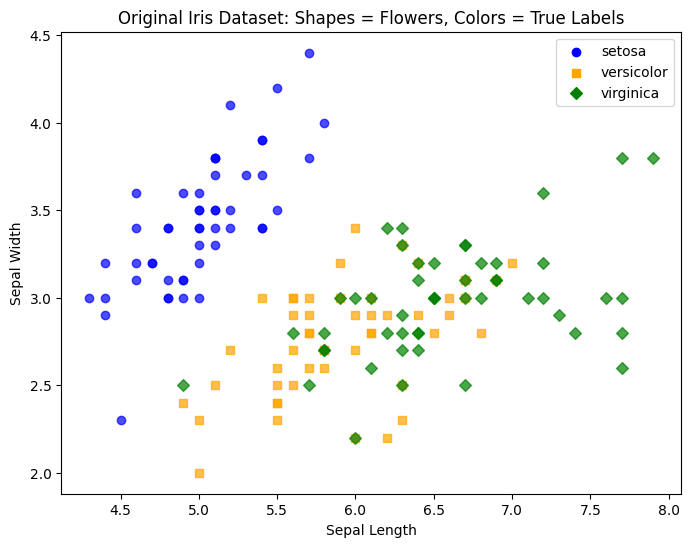

In [78]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
X, y = iris.data.values, iris.target.values

markers = ['o', 's', 'D']
flower_colors = ['blue', 'orange', 'green']

plt.figure(figsize=(8, 6))
for i in range(len(X)):
    plt.scatter(X[i, 0], X[i, 1],
                marker=markers[y[i]],
                color=flower_colors[y[i]],
                alpha=0.7)

for i, name in enumerate(iris.target_names):
    plt.scatter([], [], marker=markers[i], color=flower_colors[i], label=f"{name}")

plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Original Iris Dataset: Shapes = Flowers, Colors = True Labels')
plt.legend()
plt.show()

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
k = 3

final_centroids, cluster_labels, final_cost = kmeans(X_train, k)
full_labels = assign_clusters(X, final_centroids)

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 1, Distortion Function Value: 94.10204101194219
Iteration 2, Distortion Function Value: 68.83680513784464
Iteration 3, Distortion Function Value: 65.67295971867009
Iteration 4, Distortion Function Value: 65.49057205029013
Iteration 5, Distortion Function Value: 65.38870833333335
Iteration 6, Distortion Function Value: 65.08155000000002
Iteration 7, Distortion Function Value: 64.88272836375931
Iteration 8, Distortion Function Value: 64.88272836375931


## Predicting Membership

Once K-Means clustering is trained, we need a method to **assign new data points** to existing clusters. Unlike DBSCAN, K-Means relies on **centroids**, so prediction is straightforward: a new point is assigned to the **nearest centroid**.

For a new data point $ x $, we compute its distance to all cluster centroids and assign it to the closest one.
Given:
- **Cluster centroids** $ C = \{ c_1, c_2, ..., c_k \} $
- **New point** $ x $

We find the closest centroid by computing the **Euclidean distance**:

$$
d(x, c_i) = \sqrt{\sum_{j=1}^{n} (x_j - c_{i,j})^2}
$$

The point is assigned to the cluster whose centroid has the **smallest distance**:

$$
\text{Cluster}(x) = \arg\min_{i} d(x, c_i)
$$


In [80]:
from sklearn.metrics.pairwise import euclidean_distances

def predict_kmeans(data, centroids):
    distances = euclidean_distances(data, centroids)
    return np.argmin(distances, axis=1)

random_index = np.random.randint(len(iris.data.values))
actual_point = iris.data.values[random_index]
actual_label = iris.target.values[random_index]

noisy_point = actual_point + np.random.normal(0, 0.1, size=actual_point.shape)
predicted_cluster = predict_kmeans(noisy_point.reshape(1, -1), final_centroids)

print("Original Data Point:", actual_point)
print("True Label:", actual_label)
print("Noisy Data Point:", noisy_point)
print("Predicted Cluster for Noisy Point:", predicted_cluster)

Original Data Point: [5.  3.5 1.3 0.3]
True Label: 0
Noisy Data Point: [4.91036648 3.48880122 1.44689413 0.18761017]
Predicted Cluster for Noisy Point: [2]


Visualize with plots

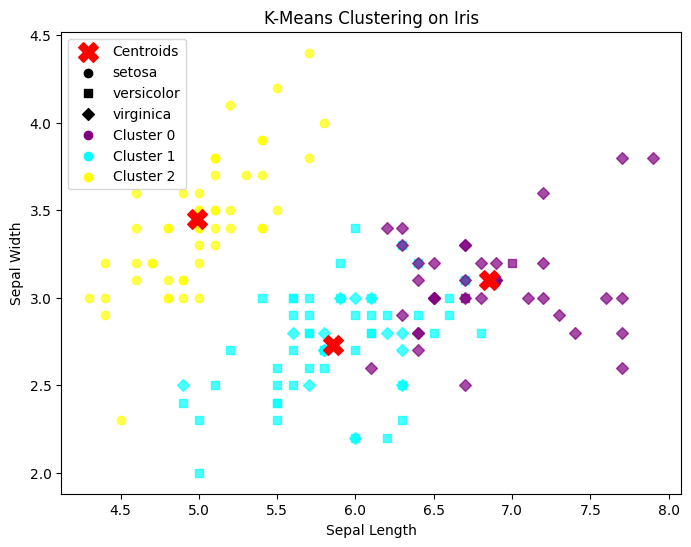

In [81]:
cluster_colors = ['purple', 'cyan', 'yellow']
plt.figure(figsize=(8, 6))
for i in range(len(X)):
    plt.scatter(X[i, 0], X[i, 1],
                marker=markers[y[i]],
                color=cluster_colors[full_labels[i]],
                alpha=0.7)

plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='red', marker='X', s=200, label="Centroids")
for i, name in enumerate(iris.target_names):
    plt.scatter([], [], marker=markers[i], color='black', label=f"{name}")
for i in range(k):
    plt.scatter([], [], color=cluster_colors[i], marker='o', label=f"Cluster {i}")

plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('K-Means Clustering on Iris')
plt.legend()
plt.show()

# Elbow Method for Optimal K

This is taken from the k-NN notebook you have previously studied. But as a reminder:

Compute second derivative (discrete approximation) to find the curvature or elbow:


First Derivative ($f'(k)$)
- Measures the **rate of change** of the error function.
- A **steep negative slope** means the error is **decreasing rapidly**.
- A **flatter slope** means the reduction in error is **slowing down**.

Second Derivative ($f''(k)$)
- Measures the **curvature** of the error function.
- A **high second derivative** indicates a **sharp change in slope**.
- The **"elbow" point** occurs at the **maximum curvature**, where: $ f''(k) = \max f''(k) $

  0%|          | 0/10 [00:00<?, ?it/s]

Optimal k found at: 2


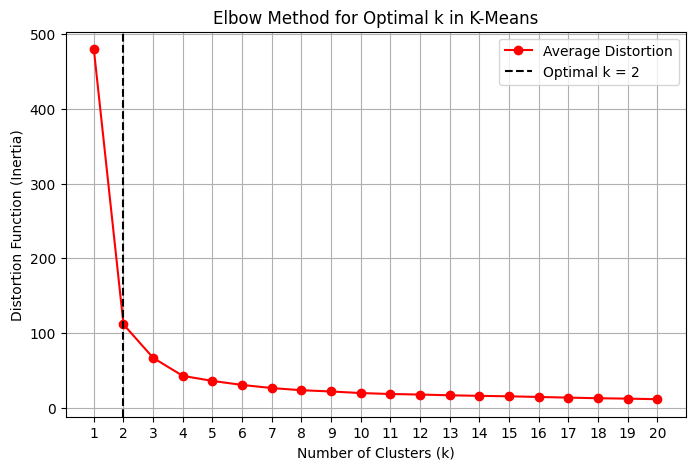

In [82]:
k_values = range(1, 21)
num_runs = 10
errors = np.zeros(len(k_values))

for r in tqdm(range(num_runs)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=r)
    for i, k in enumerate(k_values):
        final_centroids, cluster_labels, final_cost = kmeans(X_train, k, log=False)
        errors[i] += final_cost

errors /= num_runs
curvature = np.diff(errors, 2)  # Second derivative
optimal_k = k_values[np.argmax(curvature) + 1]  # Elbow at max curvature
print(f"Optimal k found at: {optimal_k}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o', linestyle='-', color='r', label="Average Distortion")
plt.axvline(optimal_k, linestyle="--", color="black", label=f"Optimal k = {optimal_k}")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion Function (Inertia)")
plt.title("Elbow Method for Optimal k in K-Means")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

# Conclusion

We explored the **K-Means clustering algorithm**, an **unsupervised machine learning technique** used to partition data into **K clusters** by minimizing intra-cluster variance. The algorithm iteratively refines cluster assignments until convergence.

Key components of K-Means:
- **Centroid Initialization**: Initial cluster centers are selected randomly.
- **Cluster Assignment**: Each data point is assigned to the nearest centroid.
- **Centroid Update**: The centroids are recalculated as the mean of assigned points.
- **Iteration Until Convergence**: The process repeats until centroids stabilize.

To determine the nearest centroids, we implemented and analyzed multiple **distance functions**:
- **Euclidean Distance**: Measures straight-line distance, widely used in K-Means.
- **Manhattan Distance**: Uses absolute differences, robust to outliers.
- **Cosine Similarity**: Measures the angle between vectors, useful for text clustering.
- **Jaccard Similarity**: Evaluates set-based similarity, ideal for binary/categorical data.
- **Minkowski Distance**: Generalization of Euclidean and Manhattan distances.
- **Mahalanobis Distance**: Adjusts for correlated features.
- **Hamming Distance**: Measures differences in categorical/binary data.

What we learned:
- **K-Means minimizes the distortion function** to optimize cluster quality.
- **Different distance metrics affect clustering results**, and Euclidean distance is the most common for K-Means.
- **K-Means does not inherently learn class labels**, requiring a post-processing step for evaluation.
- **Visualizing clusters and misclassifications** helps in understanding K-Means behavior.
- **Choosing the correct `K` is crucial** for effective clustering and can be determined using the Elbow Method.
